# Drawdowns in Finance

This notebook delves into the **construction and analysis of drawdowns** in financial assets or portfolio values over time.

---

**What is a Drawdown?**

A **drawdown** represents the **decline in an investment’s value** from its **peak** (maximum value) to its **trough** (minimum value) before a new peak is reached. It is one of the most important measures of **risk** and **volatility**, capturing not just *how much* an investment can lose, but also *how long* it takes to recover.

In Mathematica terms, the drawdown at time *t* is typically expressed as a **percentage decline from the running maximum**:

$$
\text{Drawdown}_t = \frac{P_t - P_{peak}}{P_{peak}} = \frac{P_t}{P_{peak}} - 1
$$

Where:
- $P_t$ = current portfolio or asset value at time *t* 
- $P_{peak}$ = highest value reached up to time *t*

Thus, a drawdown of -0.25 means the portfolio is **25% below its historical peak**.

**Why Drawdowns Matter**

Drawdowns provide a **realistic measure of downside risk** — they show how far and how long a portfolio can fall before recovering. Unlike volatility (which treats upside and downside equally), drawdowns focus solely on **loss periods** and their severity. Key metrics derived from drawdowns include:

| Metric | Description |
|--------|--------------|
| **Maximum Drawdown (MDD)** | The largest historical drop from peak to trough. Measures the worst loss experienced. |
| **Drawdown Duration** | The length of time the portfolio stays below its previous peak (i.e., how long it takes to recover). |
| **Recovery Time** | The period between the trough and when a new peak is reached. |

From this notebook, you will learn the following:

1. **How to compute drawdowns** using cumulative peak tracking.  
2. **How to visualize drawdown periods** on a time series chart.  
3. **How to measure maximum drawdown and duration** programmatically.  
4. **Interpretation of drawdowns** as indicators of portfolio resilience and risk exposure.

---

Before moving on, let us take some time to analyse a simple example without any form of coding. Suppose your portfolio grows from \$100 → \$120 → \$90 → \$130:

| Time | Portfolio Value | Running Peak | Drawdown |
|------|------------------|---------------|-----------|
| t₁ | 100 | 100 | 0.00 |
| t₂ | 120 | 120 | 0.00 |
| t₃ | 90  | 120 | -0.25 |
| t₄ | 130 | 130 | 0.00 |

At *t₃*, the portfolio suffers a **25% drawdown**, which is fully recovered by *t₄*.

With that, let us begin!

Import the libraries that we will be using for this drawdown analysis

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Over here, we are going to import the historical data of SPY and TSLA, followed by a detailed analysis of drawdowns

In [2]:
univ = ['TSLA','SPY'] # Create a list of ticker symbols
px = yf.download(univ, start="2021-01-01")['Close'] # Download historical closing prices
px.head() # Display the first few rows of the DataFrame

/var/folders/5v/9xrz7nmd29s2z029pvbqs8r00000gn/T/ipykernel_24219/3259074855.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(univ, start="2021-01-01")['Close'] # Download historical closing prices
[*********************100%***********************]  2 of 2 completed


Ticker,SPY,TSLA
Date,,
2021-01-04,344.256714,243.256668
2021-01-05,346.627808,245.036667
2021-01-06,348.700043,251.993332
2021-01-07,353.880920,272.013336
2021-01-08,355.897247,293.339996


Recall that drawdown is simply the percentage difference between the peak and trough, divided by the peak's value


**Mathematical Notation:**

$$
\text{Drawdown} = \frac{P_{peak} - P_{trough}}{P_{peak}}
$$

Where:  
- $P_{peak}$ = highest portfolio (or asset) value before the decline  
- $P_{trough}$ = lowest portfolio (or asset) value after the decline  

---

**Example:**

If your portfolio peaks at **\$120,000** and drops to **\$90,000**:

$$
\text{Drawdown} = \frac{120{,}000 - 90{,}000}{120{,}000} = 0.25 = 25\%
$$


Let us define a function for drawdown.

- Frist, we will take in a pandas series or dataframe
- Second, we will use the *expanding()* method that creates a cumulative window that grows over time (unlike a fixed-size rolling window). The max() inside it computes the maximum price observed so far at each point in time.

In [5]:
def drawdown(px):
  return (px / px.expanding(min_periods=1).max() - 1)

In [6]:
# Output the drawdown dataframe
dd = drawdown(px)
dd.tail()

Ticker,SPY,TSLA
Date,,
2026-01-09,0.000000,-0.091594
2026-01-12,0.000000,-0.083531
2026-01-13,-0.001999,-0.087123
2026-01-14,-0.006905,-0.103454
2026-01-15,-0.004200,-0.104740


Expand the chart to see drawdowns

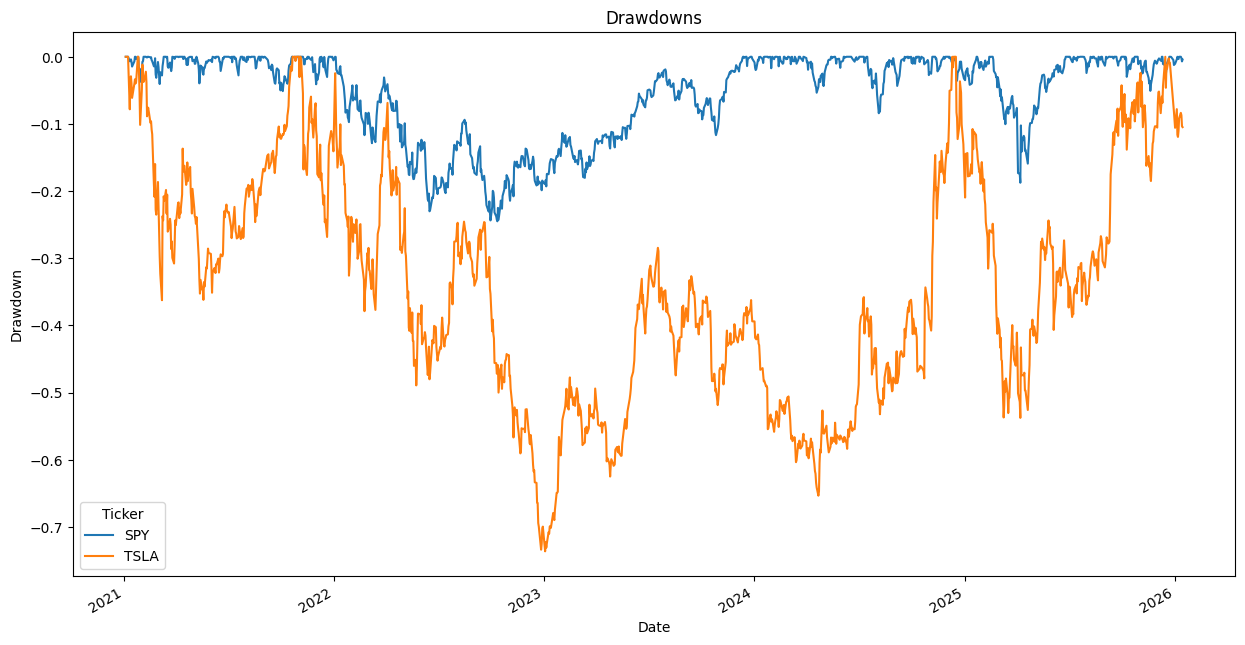

In [8]:
dd.plot(title='Drawdown of Asset Over Time')
plt.title("Drawdowns")
plt.xlabel("Date")
plt.ylabel("Drawdown") 
plt.gcf().set_size_inches(15, 8) # Increase the size of the plot for better visibility
plt.show()


What we see above is a drawdown of the two assets across time, the maximum value is 0%, which is where we are essentially breakeven in terms of price. Each dip we are see references the duration and depth of the drawdown once we have past a maximum during the expanding window phase. 

For instance, a local maxima was reached sometime in late 2021, afterwhich price has dipped below that maximum value and only recovered to reach back that value sometime in late 2024

In [9]:
# We can also find the maximum drawdown for each asset
dd.min()

Ticker
SPY    -0.244964
TSLA   -0.736322
dtype: float64

So far, we have plotted the drawdown charts for our assets and retrieved their maximum drawdown. Next up, we want to answer the question of 'how long is our drawdown'? 

In [10]:
def duration(px):
  peak = px.expanding(min_periods=1).max() # Retrieve the peak price over the course of our expanding window
  res = pd.DataFrame(index=px.index,columns=px.columns) # Initialize an empty dataframe to store our results
  
  for col in px.columns:
    for dt in px.index:
      """ if statement:
        If the current price is equal to the running peak, it means we have hit a new all-time high, so the drawdown ends and duration resets to 0.
      """
      """ else statement:
        If the current price is below the peak, that means we are still in a drawdown.
        The code looks at the previous duration value (the second last row, .iloc[-2]) and then adds +1, meaning another period has passed since the last peak.
        So duration keeps counting how many consecutive periods we’ve been under the last peak.
      """
      if px.loc[dt,col] >= peak.loc[dt,col]:
        res.loc[dt,col] = 0
      else:    
        res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1
  return res

In [11]:
ddd = duration(px)
ddd.tail()

Ticker,SPY,TSLA
Date,,
2026-01-09,0,16
2026-01-12,0,17
2026-01-13,1,18
2026-01-14,2,19
2026-01-15,3,20


With that, we can now plot the duration of our drawdowns

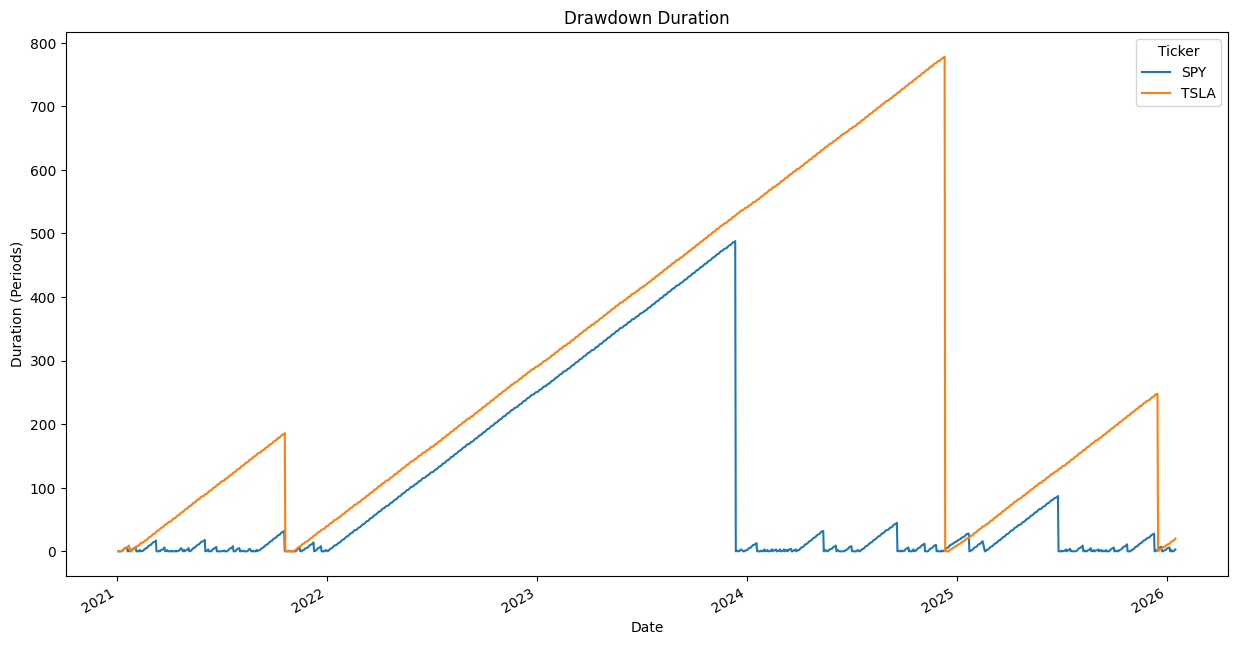

In [13]:
ddd.plot(title='Duration of Drawdown of Asset Over Time')
plt.title("Drawdown Duration")
plt.xlabel("Date")
plt.ylabel("Duration (Periods)") 
plt.gcf().set_size_inches(15, 8) # Increase the size of the
plt.show()

In [14]:
# Output the maximum duration of drawdowns for each asset
ddd.max()

Ticker
SPY     488
TSLA    778
dtype: object

Having the depth (%) and duration (periods) of our drawdowns above are useful measures that we can include in our strategy performance evaluation. However, it is also good if we can visualise how drawdown is like on the price chart of the asset in focus. 

With that, we will plot the horizontal line to illustrate our drawdown in the chart for TSLA and SPY

In [15]:
# define the function to generate a dataframe containing price of each local maxima
def drawdown_with_line(px):
  dataframe = pd.DataFrame(index=px.index,columns=px.columns)  
  peak = px.expanding(min_periods=1).max()
  for col in px.columns:
    for dt in px.index:
      """ This is a slight modification of the if statement used in the duration function.
      if the current price is equal to or greater than the running peak, we set the value in our new dataframe
      to the current price (indicating a new peak). Otherwise, we set it to the previous peak value.
      """
      if px.loc[dt,col] >= peak.loc[dt,col]:
        dataframe.loc[dt,col] = px.loc[dt,col]
      else:
        dataframe.loc[dt,col] = peak.loc[dt,col]
  return dataframe
  

Plot the horizontal line to illustrate our drawdown in the chart for TSLA

maximum drawdown for TSLA: -0.736322174421912


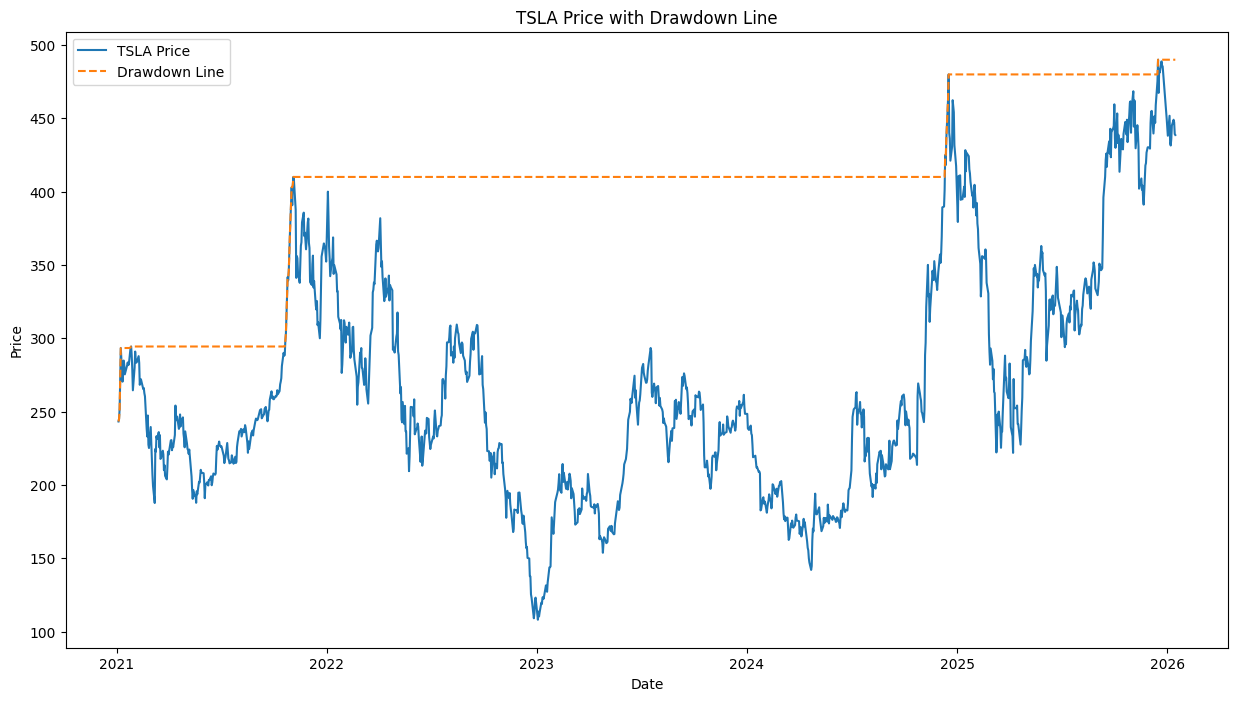

In [16]:
hdd = drawdown_with_line(px)
horiz_line = hdd['TSLA']
print("maximum drawdown for TSLA:", dd['TSLA'].min())
plt.figure(figsize=(15, 8))
plt.plot(px['TSLA'], label='TSLA Price')
plt.plot(horiz_line, label='Drawdown Line', linestyle='--')
plt.title("TSLA Price with Drawdown Line")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

What this does is that we are essentially plotting the line that runs from every local maxima as we advance forward in time.

maximum drawdown for SPY: -0.2449639343974439


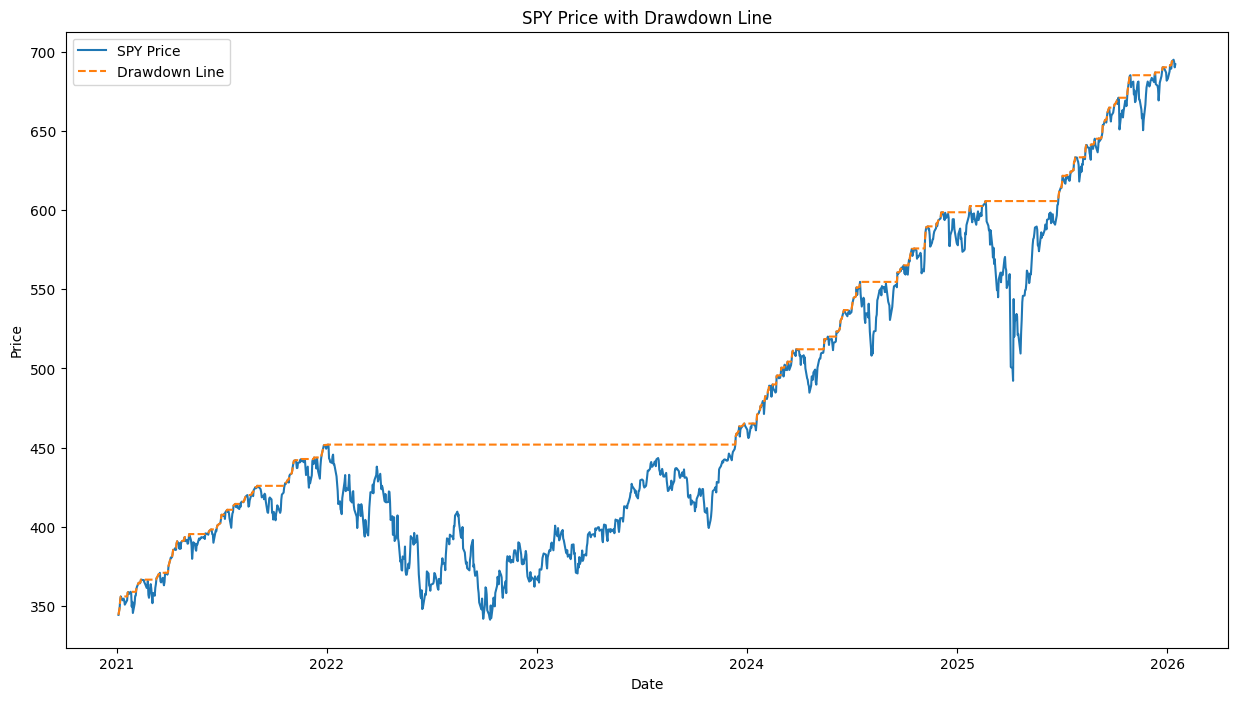

In [17]:
# Plot the horizontal line to illustrate our drawdown in the chart for SPY
hdd = drawdown_with_line(px)
horiz_line = hdd['SPY']
print("maximum drawdown for SPY:", dd['SPY'].min())
plt.figure(figsize=(15, 8))
plt.plot(px['SPY'], label='SPY Price')
plt.plot(horiz_line, label='Drawdown Line', linestyle='--')
plt.title("SPY Price with Drawdown Line")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()